<a href="https://colab.research.google.com/github/ramahasiba/NLP/blob/langGraph/Build_a_Retrieval_Augmented_Generation_App.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Build a Retrieval Augmented Generation (RAG) App: Part 1](https://python.langchain.com/docs/tutorials/rag/)
In this tutorial, we design an aplication that can answer questions about speific source information. These application use a technique known as Retrieval Augmented Generation(RAG).

Below we build a simple Q&A application over a text data source.

## Setup

In [1]:
%pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 14.0 MB/s eta 0:00:00


In [2]:
!pip install dotenv -q

In [3]:
!pip install dotenv -q
from dotenv import load_dotenv
try:
  load_dotenv('.env')
except ImportError:
  print('No .env file found')

### LangSmith

In [4]:
import getpass
import os

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = os.environ.get("LANGSMITH_API_KEY")

In [5]:
!pip install -qU "langchain[groq]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.1/131.1 kB 3.4 MB/s eta 0:00:00


### LLM - Groq

In [6]:
os.environ["GROQ_API_KEY"]=os.environ.get("GROQ_API_KEY")

model_name = "llama3-70b-8192"

from langchain.chat_models import init_chat_model
llm=init_chat_model(model_name, model_provider="groq")

### Embedding from HuggungFace

In [7]:
!pip install -qU langchain-huggingface

In [8]:
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### Vector Database - Chroma DB

In [9]:
!pip install -qU langchain-chroma

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 1.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 84.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 65.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 81.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.6/201.6 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 7.6 MB/s eta 

In [10]:
from langchain_chroma import Chroma

vector_store = Chroma(
    collection_name="RAG",
    embedding_function=embeddings,
    persist_directory="./chroma_langchain_db",
    # client_settings=settings
)

This app will answer questions about a website's content. The specific website we used is the [LLM Powered Autonomous Agetns](https://lilianweng.github.io/posts/2023-06-23-agent/) blog post. which allow us to ask questions about the contents of the post.

In [11]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

# Index chunks
_ =  vector_store.add_documents(documents=all_splits)

# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")

# Define state for application
class State(TypedDict):
  question: str
  context: List[Document]
  answer: str

# Define application steps
def retrieve(state: State):
  retrieved_docs = vector_store.similarity_search(state["question"])
  return {"context": retrieved_docs}

def generate(state: State):
  docs_content = "\n\n".join(doc.page_content for doc in state["context"])
  messages = prompt.invoke({"question": state["question"], "context": docs_content})
  response = llm.invoke(messages)
  return {"answer": response.content}

# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

In [12]:
response = graph.invoke({"question": "What is Task Decomposition?"})
print(response["answer"])

Task decomposition is the process of breaking down a complex task into smaller, manageable steps or subtasks. This can be done through various methods, including using large language models (LLMs) with simple prompting, task-specific instructions, or human inputs. The goal of task decomposition is to make it easier to plan and execute a task by identifying the individual steps required to complete it.


## Indexing

### Loading Documents

In [13]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# Only keep post title, headers, and content from the full HTML.
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load() # this returns a list of Document objects

assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

Total characters: 43047


In [14]:
print(docs[0].page_content[:500])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


### Splitting Documents
The loaded document is over 42K, which is too long to fit into the context window of may models. Even if model that could fit the full post in thier context window, models caan struggle to find information in very long inputs.

In [15]:
# RecursiveCharacterTextSplitter is recommended for generic text use cases.
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    add_start_index=True,
)

all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 63 sub-documents.


### Storing Documents

Here we index the text chunks so that we can search over them at runtime. we embed the splits and then insert hose embeddings into a vector store.

In [16]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:4])

['42f2f769-3aba-44ba-af3b-7cb2852d622e', '34b51f81-910f-4eda-bf24-36d65453241e', 'f29f5da1-6212-4d77-a53e-ad6e5a4cbb7d', '547d4301-fc6f-478b-827d-5f8320dc5dc2']


## Retrieval and Generation
Here we used LangGraph to tie together the retrieval and generation steps into a single application.

In [17]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke({
    "context": "(context goes here)",
    "question": "(question goes here)"
}).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


## Define the State
The state of our application controls what data is input to the application, transferred between steps, and output by the application. For this simple RAG application we keep track of the following:
* input question
* retrieved context
* generated answer

In [18]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict

class State(TypedDict):
  question: str
  context: List[Document]
  answer: str

## Nodes (application steps)
We start with a simple sequence of two steps:
* Retrieval
* Generation

In [19]:
def retrieve( state: State):
  # run a similarity search using the input question
  retrieved_docs = vector_store.similarity_search(state["question"])
  return {"context": retrieved_docs}

def generate(state: State):
  docs_content = "\n\n".join(doc.page_content for doc in state["context"])
  # format the retrieved context and original question into a prompt for the chat model
  messages = prompt.invoke({"question": state["question"], "context": docs_content})
  response = llm.invoke(messages)
  return {"answer": response.content}

## Control Flow
compile the application into a single graph object. Here we just connect the retrieval and generation steps into a single sequence.

In [20]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

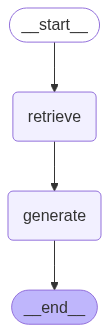

In [21]:
graph

## Graph Usage - Testing

### Invoke:

In [22]:
# Invoke
result = graph.invoke({"question": "What is task decomposition?"})

print(f"Context: {result['context']}")
print(f"Answer: {result['answer']}")

Context: [Document(id='316f81c2-0e59-40b0-8ed2-84b5fb24a705', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially, the planning step is outsourced to an external tool, assuming the availab

In [23]:
# Invoke
result = graph.invoke({"question": "tell me about task decomposition?"})

print(f"Context: {result['context']}")
print(f"Answer: {result['answer']}")

Context: [Document(id='316f81c2-0e59-40b0-8ed2-84b5fb24a705', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially, the planning step is outsourced to an external tool, assuming the availab

### Streaming Tokens:

In [24]:
for step in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='316f81c2-0e59-40b0-8ed2-84b5fb24a705', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially, the planning step is outsourced to an external tool, assu

In [25]:
for message, metadata in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="messages"
):
    print(message.content, end="|")

|Task| decomposition| is| the| process| of| breaking| down| a| complicated| task| into| smaller|,| more| manageable| steps|.| This| can| be| done| through| various| methods|,| including| using| language| models| with| simple| prompting|,| task|-specific| instructions|,| or| human| inputs|.| The| goal| of| task| decomposition| is| to| help| an| agent| plan| ahead| and| know| what| steps| are| involved| in| completing| a| complex| task|.||

### Prompt Customization
Customizing the prompt instead of loading it from the prompt hub

In [35]:
from langchain_core.prompts import PromptTemplate

template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.
If there is no relevant context, just say that you don't know.

{context}

Question: {question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)

## Query Analysis
Here the model rewrite user queries, which may be multifaceted or include irrelevant language, into more effective search queries.

In [36]:
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"


all_splits[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'start_index': 8,
 'section': 'beginning'}

In [37]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)

### Schema Definition
Here we define a schema for the search query. we will use structured putput for this purpose.

In [38]:
from typing import Literal

from typing_extensions import Annotated


class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]

Here the LangGraph application generate a query from user's raw input.

In [39]:
class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str


def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}


def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"],
    )
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

In [41]:
for step in graph.stream(
    {"question": "What does the post say about Task Decomposition?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'Task Decomposition', 'section': 'beginning'}}}

----------------

{'retrieve': {'context': [Document(id='c9c3d98f-1288-401f-a99e-3616a7f56970', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2578, 'section': 'beginning'}, page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Dom

**Note that changing user query may generates error**

In [ ]:
for step in graph.stream(
    {"question": "What does the end of the post say about Task Decomposition?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

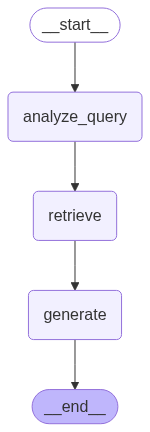

In [43]:
graph